## Richter's Predictor: Modeling Earthquake Damage

https://www.drivendata.org/competitions/57/nepal-earthquake

Este simple código otorga un F1 de 0.740, suficiente para ubicarse dentro del 10% de la competencia y bastante cercano al primer lugar (F1=0.756).

Tanto el código como los comentarios se encuentran actualmente en desarrollo.

[EDA](#Exploratory-Data-Analysis)

[FE](#Feature-Engineering)

[Bechmark](#Bechmark)

[Modelo](#Model)

In [1]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from itertools import combinations
from sklearn.linear_model import LogisticRegression
import mord 

def variable_threshold(variable,threshold):
    counts = variable.value_counts()
    replaced = counts[counts <= threshold].index
    variable_threshold=variable.replace(replaced, 99999)
    return variable_threshold

def ratios_combination(Dataframe,Columns): 
    lista_combinatoria=list(combinations(Columns,2))
    Data=[]
    indice=[(x+'R'+y) for (x,y) in lista_combinatoria]
    for combi in lista_combinatoria:
        Data.append(Dataframe[combi[0]]/Dataframe[combi[1]])
    return pd.DataFrame(Data,index=indice).T

root = os.path.abspath('D:\drivendata\earthquake\data')
train_y=DB = pd.read_csv(os.path.join(root + '/train_labels.csv'))
train_x=DB = pd.read_csv(os.path.join(root + '/train_values.csv'))



## Exploratory Data Analysis

Primero realizamos un análisis preliminar sobre las variables

In [2]:
train_x.nunique()

building_id                               260601
geo_level_1_id                                31
geo_level_2_id                              1414
geo_level_3_id                             11595
count_floors_pre_eq                            9
age                                           42
area_percentage                               84
height_percentage                             27
land_surface_condition                         3
foundation_type                                5
roof_type                                      3
ground_floor_type                              5
other_floor_type                               4
position                                       4
plan_configuration                            10
has_superstructure_adobe_mud                   2
has_superstructure_mud_mortar_stone            2
has_superstructure_stone_flag                  2
has_superstructure_cement_mortar_stone         2
has_superstructure_mud_mortar_brick            2
has_superstructure_c

In [3]:
train_x.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

Definimos variables según su naturaleza (numérica, categórica o binaria)

In [4]:
numeric_columns=[
'count_families',
'count_floors_pre_eq',
'age',
'area_percentage',
'height_percentage',
]

In [5]:
categorical_columns=[#'building_id',
'geo_level_3_id',
'geo_level_2_id',
'geo_level_1_id',
'plan_configuration',
'foundation_type',
'ground_floor_type',
'other_floor_type',
'position',
'legal_ownership_status',
'land_surface_condition',
'roof_type'
]

In [6]:
boolean_columns=['has_superstructure_adobe_mud',
'has_superstructure_mud_mortar_stone',
'has_superstructure_stone_flag',
'has_superstructure_cement_mortar_stone',
'has_superstructure_mud_mortar_brick',
'has_superstructure_cement_mortar_brick',
'has_superstructure_timber',
'has_superstructure_bamboo',
'has_superstructure_rc_non_engineered',
'has_superstructure_rc_engineered',
'has_superstructure_other',
'has_secondary_use',
'has_secondary_use_agriculture',
'has_secondary_use_hotel',
'has_secondary_use_rental',
'has_secondary_use_institution',
'has_secondary_use_school',
'has_secondary_use_industry',
'has_secondary_use_health_post',
'has_secondary_use_gov_office',
'has_secondary_use_use_police',
'has_secondary_use_other'
]


In [7]:
train_x[categorical_columns].nunique().sum()


13078

In [8]:
train_x['geo_level_3_id']=variable_threshold(train_x['geo_level_3_id'],99)
encoder_threshold_list=train_x['geo_level_3_id'].drop_duplicates().tolist()

In [9]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(train_x[categorical_columns])
OHE_nombres=encoder.get_feature_names(train_x[categorical_columns].columns)
OHE_train_df=pd.DataFrame(encoder.transform(train_x[categorical_columns]).toarray(),columns=OHE_nombres,dtype=int)

num_cols_minus_age=[x for x in numeric_columns if x != 'age']

train_ratios=ratios_combination(train_x,num_cols_minus_age)
train_df1=pd.DataFrame.join(train_x[numeric_columns+boolean_columns],train_ratios)
train_df=pd.DataFrame.join(train_df1,OHE_train_df)

In [10]:
train_y=train_y['damage_grade']
train_y=train_y-1

Por motivos de reproducibilidad agregamos una semilla arbitraria.
np.random.seed(777)

In [11]:
X_train, X_test, y_train, y_test=train_test_split(train_df,train_y,test_size=0.2,stratify=train_y)

## Bechmark

In [12]:
Logit = LogisticRegression(multi_class='ovr',max_iter=500)
Logit.fit(X_train,y_train)
Logit_pred = Logit.predict(X_test)
f1_score(y_test.values, Logit_pred,average='micro')

C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

0.7123999923255503

In [13]:
Ologit = mord.LogisticAT() 
Ologit.fit(X_train,y_train)
Ologit_pred=Ologit.predict(X_test)
f1_score(y_test.values, Ologit_pred,average='micro')

0.7114982444695996

## Model

In [14]:
train_data = lgb.Dataset(X_train , label = y_train, free_raw_data=False)

In [15]:
fake_valid_data = lgb.Dataset(X_test, label = y_test,
                 free_raw_data=False)

In [16]:
def lgb_f1_score(y_pred, dtrain):
    y_true = dtrain.get_label()    
    preds = y_pred.reshape(len(np.unique(y_true)), -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds,average='micro'), True

In [17]:
params={"early_stopping_rounds":400, 
            "objective" : 'multiclass',
            "metric": 'multi_logloss',
            "learning_rate": 0.05,
            "min_data_in_leaf": 5,
            "boosting":'gbdt',
            "max_leaves": 255,
            "max_bin":511,
            'num_class': 3} 

In [18]:
m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=50, num_boost_round=2000,feval=lgb_f1_score)


C:\Users\Francisco\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4271
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 1686
[LightGBM] [Info] Start training from score -2.339173
[LightGBM] [Info] Start training from score -0.564028
[LightGBM] [Info] Start training from score -1.094582
Training until validation scores don't improve for 400 rounds
[50]	valid_0's multi_logloss: 0.61422	valid_0's f1: 0.729245
[100]	valid_0's multi_logloss: 0.589156	valid_0's f1: 0.737054
[150]	valid_0's multi_logloss: 0.581372	valid_0's f1: 0.739241
[200]	valid_0's multi_logloss: 0.578498	valid_0's f1: 0.73997
[250]	valid_0's multi_logloss: 0.577076	valid_0's f1: 0.740239
[300]	valid_0's multi_logloss: 0.576476	valid_0's f1: 0.740431
[350]	valid_0's multi_logloss: 0.576317	va

In [19]:
test_x=DB = pd.read_csv(os.path.join(root + '/test_values.csv'))
encoder_threshold_bool=test_x['geo_level_3_id'].isin(encoder_threshold_list)
test_x['geo_level_3_id']=(encoder_threshold_bool*test_x['geo_level_3_id']).replace(0,99999)
OHE_nombres=encoder.get_feature_names(test_x[categorical_columns].columns)
OHE_test_df=pd.DataFrame(encoder.transform(test_x[categorical_columns]).toarray(),columns=OHE_nombres,dtype=int)
test_ratios=ratios_combination(test_x,num_cols_minus_age)
test_df1=pd.DataFrame.join(test_x[numeric_columns+boolean_columns],test_ratios)
test_df=pd.DataFrame.join(test_df1,OHE_test_df)

Hacemos un sanity check de la distribución de las proyecciones, si las poblaciones son similares debiesen ser porcentajes similares.

In [20]:
aux=m_lgb.predict(test_df)
aux.round().sum(axis=0)/aux.round().sum()

array([0.06962777, 0.64999236, 0.28037987])

In [21]:
aux2=m_lgb.predict(train_df)
aux2.round().sum(axis=0)/aux2.round().sum()


array([0.07264547, 0.64388592, 0.28346861])

In [22]:
pred_train=pd.DataFrame(aux2.argmax(axis=1))
print(f1_score(train_y, pred_train, average='micro'))
pred_test=pd.DataFrame(aux.argmax(axis=1),columns=['damage_grade'])+1

0.7930437718965008


In [23]:
submission=pd.concat([test_x['building_id'],pred_test],axis=1)
submission.to_csv('submission.csv',sep=",",index=False)

Por motivos de interpretabilidad, graficamos las variables más relevantes del modelo.

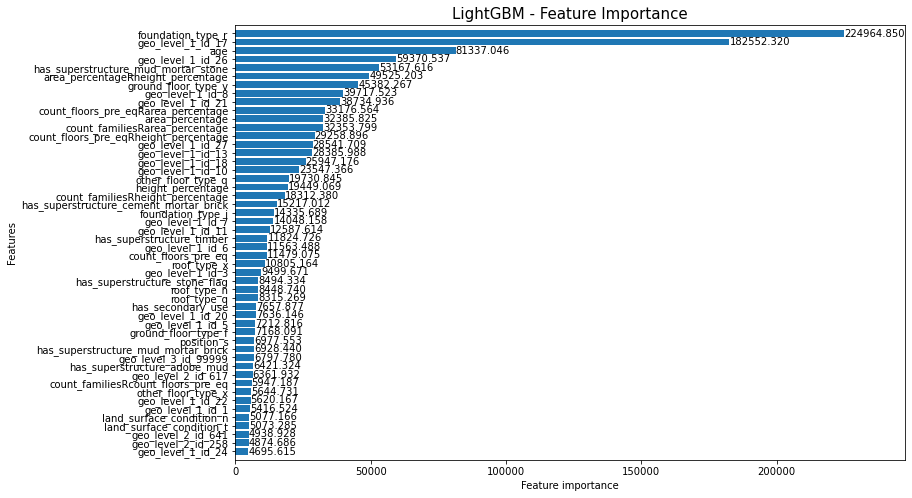

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18.0, 4)


fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax,importance_type='gain')
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

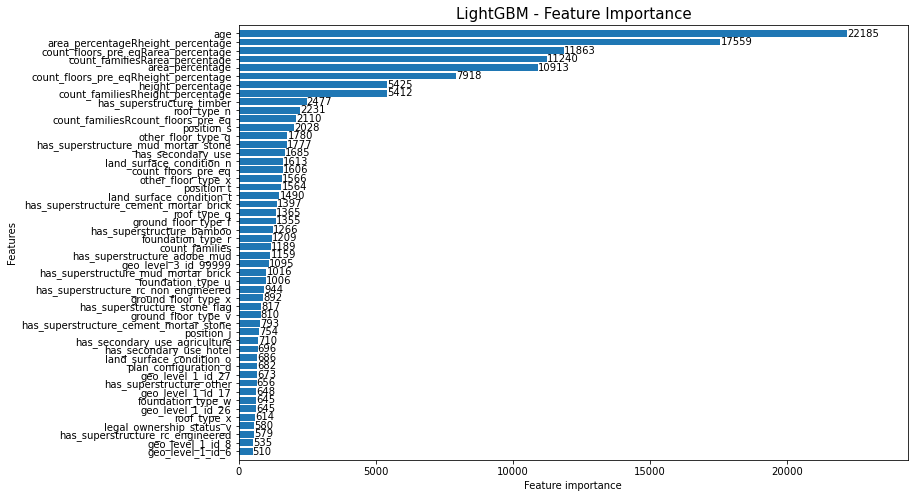

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax,importance_type='split')
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## En desarrollo